<a href="https://colab.research.google.com/github/SerenaParve/Property_Price_Regression/blob/main/Property_Price_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is a project to do regression analysis for real estate properties. The data for this project was given by Professor Johan Van Dorp for my class - EMSE 6765 (Fall 2022) at George Washington University.

The following regression was first done using Excel and Minitab. This notebook is an attempt to replicate that in python.

In the notebook we will observe the difference between multiple linear regression done with sklearn and with statsmodels - or more importantly, the difference between the gradient descent method (sklearn) and the OLS method (statsmodels)

A number of factors can be used to determine the price of a real estate property. In this report a dataset of 80
properties with 10 features is used to perform regression analysis to describe the relationship between the price
and the features of the property.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
'''
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Property_Price/property.csv')
df.head(5)

,Property,PRICE,bedrooms,bathrooms,sqft_living,sqft_lot,floors,Numbers of times viewed,Quality Grade,sqft_above,sqft_basement,Built or Renovated
0,1,"$440,000.00",3,2.50,1910,66211,2.0,0,7,1910,0,1997
1,2,"$213,000.00",2,1.00,1000,10200,1.0,0,6,1000,0,1961
2,3,"$563,500.00",4,1.75,2085,174240,1.0,0,7,1610,475,1964
3,4,"$1,550,000.00",5,4.25,6070,171626,2.0,0,12,6070,0,1999
4,5,"$1,600,000.00",6,5.00,6050,230652,2.0,3,11,6050,0,2001


We perform regression analysis to create a simple model that can explain the relationship between the
dependent variable (in this case the price) and the independent variables. The aim is to create a parsimonious
model with the least amount of explanatory variables while also adequately describing the variation in the
dependent variable.

In [4]:
## We change the name of some columns to keep them all in consistent formatting
df.rename(columns={' PRICE ': 'Price', 'Numbers of times viewed': 'Times_Viewed',
                   'Quality Grade': 'Quality_Grade', 'Built or Renovated': 'Built_Renovated' }, inplace=True)

In [12]:
## Checking data type of columns
df.dtypes

Property             int64
Price               object
bedrooms             int64
bathrooms          float64
sqft_living          int64
sqft_lot             int64
floors             float64
Times_Viewed         int64
Quality_Grade        int64
sqft_above           int64
sqft_basement        int64
Built_Renovated      int64
dtype: object

In [5]:
## Change the values in the price column to lose the spaces and '$' and become int
df['Price'] = df['Price'].str.replace('[\$\,]|\.\d*', '').astype(int)

<ipython-input-5-a037cbb1d42c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Price'] = df['Price'].str.replace('[\$\,]|\.\d*', '').astype(int)


Next, we get general statistics of Price:

In [16]:
## Keep price in float format and not exponential format
df.Price.describe().apply(lambda x: format(x, 'f'))

count         80.000000
mean      586120.875000
std       376718.733133
min       200000.000000
25%       340000.000000
50%       462500.000000
75%       702500.000000
max      1860000.000000
Name: Price, dtype: object

We can observe that the standard deviation is too high, which is not ideal for regression.

From Figure 1 of the EDA notebook, which depicts the histogram of Price the following observations can be made:

*  The graph is not symmetric
*  The second bar on the left is particularly high skewing the graph to the left


We can further conclude that Price is not normally distributed from the following observations made from the Probability Plot of Price (EDA nb):

*   The points do not lie on a straight line
*   The standard deviation of Price is very large

Since a more symmetric and normally distributed dependent variable is preferred for regression analysis, a transformation is performed on Price. We take the
Log of Price to the base 10.

In [6]:
df['log_p'] = df.Price.apply(np.log10)
df.head()

,Property,Price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,Times_Viewed,Quality_Grade,sqft_above,sqft_basement,Built_Renovated,log_p
0,1,440000,3,2.50,1910,66211,2.0,0,7,1910,0,1997,5.643453
1,2,213000,2,1.00,1000,10200,1.0,0,6,1000,0,1961,5.328380
2,3,563500,4,1.75,2085,174240,1.0,0,7,1610,475,1964,5.750894
3,4,1550000,5,4.25,6070,171626,2.0,0,12,6070,0,1999,6.190332
4,5,1600000,6,5.00,6050,230652,2.0,3,11,6050,0,2001,6.204120


In [17]:
df.log_p.describe().apply(lambda x: format(x, 'f'))

count    80.000000
mean      5.700886
std       0.231458
min       5.301030
25%       5.531479
50%       5.665105
75%       5.846638
max       6.269513
Name: log_p, dtype: object

Further, plotting the probability plot of Log (y), it is observed that:

*   Histogram of the Log(Price) is more symmetric as compared to hist of Price.
*   Most of the points lie on a straight line
*   There is less deviation from normality than before
*   The standard deviation of Log (Y) is much smaller compared to Y

**Thus, Log (Y) – Log of Price is used as the dependent variable in the model.**

#### Correlation

To obtain a feel for the data the correlations between the dependent variable – Log of Price and the explanatory variable is studied.
Correlation is a measure of linear dependence and thus is a good metric to understand the dependence of the variables for linear regression.

In [7]:
df = df[['log_p', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
          'floors', 'Times_Viewed', 'Quality_Grade', 'sqft_above',
          'sqft_basement', 'Built_Renovated',]]

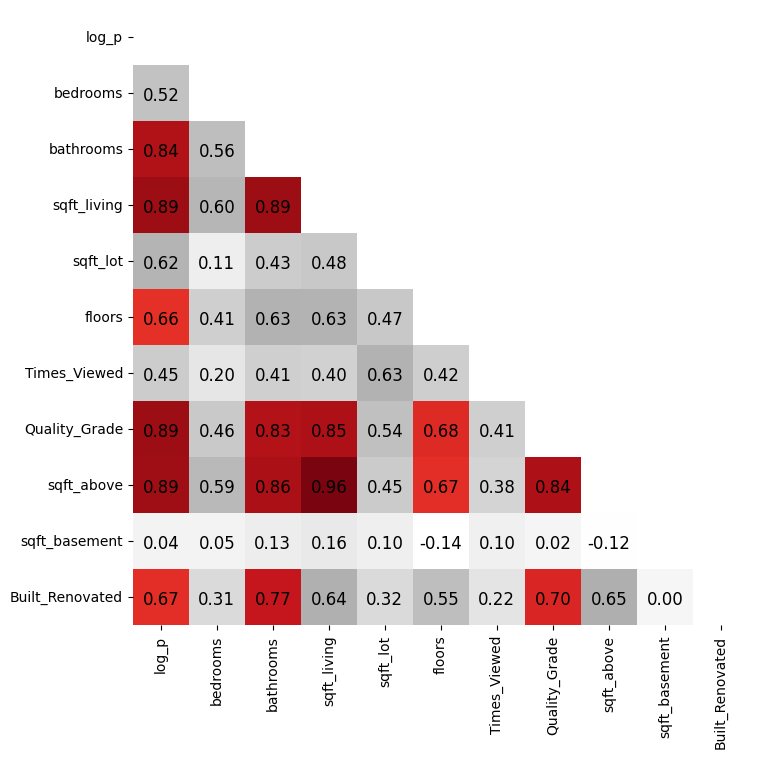

In [19]:
corr = df.corr()

# Create a mask for the upper triangle
mask_tri = np.triu(np.ones_like(corr, dtype=bool))
mask_tresh = corr < 0.65

plt.figure(figsize=(8,8))
ax = sns.heatmap(corr, cmap="Greys", center=0.8, square=True, annot=True,
                 annot_kws={"size": 12, "va": "center_baseline", "color": "black"},
                 fmt=".2f", cbar=False, mask=mask_tri)
ax = sns.heatmap(corr, mask=mask_tresh | mask_tri, cmap='Reds', square=True, annot=False, vmin=0, vmax=1, cbar=False, ax=ax)
plt.show()

Immediately 5 variables stand out as significantly correlated to Log (Y):
X2 – bathrooms

X3 – sqft_living

X5 – floors

X7 – Quality Grade

X8 – sqft_above

X10 – Built or Renovated

A model could be built including all 5 variables, however what is also noticeable from the correlation matrix is that the variables X2, X3, X7 and X8 are all highly correlated to each other.

Instead of including all of these variables in the initial model, using one of them may also be able to sufficiently explain the variation of all.

`X2` shows significant correlation to - `X3, X7, X8, and X10`

`X3` shows significant correlation to - `X2, X7, and X8`

`X5` shows significant correlation to - `X7, and X8`

`X7` shows significant correlation to - `X2, X3, X5, X7, and X8`

`X8` shows significant correlation to - `X2, X3, X5, X7, and X8`

`X10` shows significant correlation to - `X2, and X7`

Since the aim of regression is to build the most parsimonious model that would describe the variation in the variables, the variables **X3**, **X7 and X8** – the variables with largest correlations to Log (Y) are used to build the first model.

#### Graph Environment

In [18]:
import numpy as np
import scipy.stats as stats
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import Formatter, Locator


class PPFScale(mscale.ScaleBase):
    name = 'ppf'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self, axis)

    def get_transform(self):
        return self.PPFTransform()

    def set_default_locators_and_formatters(self, axis):
        class PercFormatter(Formatter):
            def __call__(self, x, pos=None):
                # \u00b0 : degree symbol
                return "%d %%" % (x*100)

        class PPFLocator(Locator):
            def __call__(self):
                return np.array([1,5,10,20,30,40,50,60,70,80,90,95,99])/100.0

        axis.set_major_locator(PPFLocator())
        axis.set_major_formatter(PercFormatter())
        axis.set_minor_formatter(PercFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 1e-6), min(vmax, 1-1e-6)

    class PPFTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def ___init__(self, thresh):
            mtransforms.Transform.__init__(self)
            self.thresh = thresh

        def transform_non_affine(self, a):
            out = stats.norm.ppf(a)
            return out


        def inverted(self):
            return PPFScale.IPPFTransform()

    class IPPFTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a):

            return stats.norm.cdf(a)

        def inverted(self):
            return PPFScale.PPFTransform()

mscale.register_scale(PPFScale)

# Regression Models

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [9]:
import statsmodels.api as sm

### Model 1 - X3, X7, X8

#### Model 1 with Sklearn (Gradient Descent)

---
`R2 - 79.4%`

Model 1, using sklearn with:

`Y = log_p`

`X = [sqft_living, sqft_above, Quality_Grade]`

In [10]:
df_m1 = df[['sqft_living', 'sqft_above', 'Quality_Grade', 'log_p']]

In [11]:
X, y = df_m1.iloc[:, :3], df_m1.iloc[:, -1]
X.shape, y.shape

((80, 3), (80,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) ## Random state = 0 so that results remain same on every run

In [25]:
ml = LinearRegression()
sklearn_m1 = ml.fit(X_train, y_train)
sklearn_m1_y_pred = sklearn_m1.predict(X_test)

In [26]:
## Predict a known value
## We use the first row of df_m1

sklearn_m1.predict([[1910, 1910, 7]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([5.60210259])

Actual value of above prediction is:

`log_p = 5.643453`

So, it is not completely accurate, but a close enough prediction.

In [27]:
from sklearn.metrics import r2_score
r2_score(y_test, sklearn_m1_y_pred)

0.7947953304841323

In [28]:
# Regressor coefficients and intercept
print(f'Coefficient: {sklearn_m1.coef_}')
print(f'Intercept: {sklearn_m1.intercept_}')

Coefficient: [6.21730883e-05 2.22955888e-05 7.49919869e-02]
Intercept: 4.915823506731017


In [34]:
predicted_value = sklearn_m1_y_pred
true_value = y_test

In [35]:
true_value.shape

(24,)

In [36]:
predicted_value.shape

(24,)

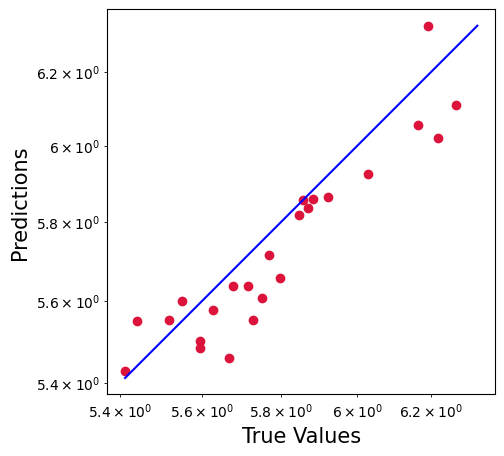

In [38]:
plt.figure(figsize=(5,5))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

#### Model 1 with StatsModels (OLS)
---
`R2- 86.1%` , `Adj. R2 - 85.6%`

In [19]:
X = sm.add_constant(X)
est_1 = sm.OLS(y, X).fit()
results_summary_1 = est_1.summary()

In [14]:
# Put the results summary of OLS in a table:
results_1 = results_summary_1.tables[0].as_html()
pd.read_html(results_1, header=0, index_col=0)[0]

,log_p,R-squared:,0.861
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,8.560000e-01
Method:,Least Squares,F-statistic:,1.571000e+02
Date:,"Fri, 22 Mar 2024",Prob (F-statistic):,1.720000e-32
Time:,21:51:59,Log-Likelihood:,8.302100e+01
No. Observations:,80,AIC:,-1.580000e+02
Df Residuals:,76,BIC:,-1.485000e+02
Df Model:,3,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [43]:
# Put the results summary of OLS in a table:
results_1 = results_summary_1.tables[1].as_html()
pd.read_html(results_1, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.965500,0.070000,71.392,0.000,4.827000,5.104000
sqft_living,0.000063,0.000029,2.204,0.031,0.000006,0.000000
sqft_above,0.000032,0.000028,1.112,0.270,-0.000025,0.000088
Quality_Grade,0.068000,0.013000,5.411,0.000,0.043000,0.093000


In [44]:
# Put the results summary of OLS in a table:
results_1 = results_summary_1.tables[2].as_html()
pd.read_html(results_1, header=0, index_col=0)[0]

,2.098,Durbin-Watson:,2.016
Omnibus:,,,
Prob(Omnibus):,0.350,Jarque-Bera (JB):,1.633
Skew:,0.174,Prob(JB):,0.442
Kurtosis:,2.393,Cond. No.,26500.000


In [22]:
import scipy
from scipy.stats import norm
import scipy.stats as stats

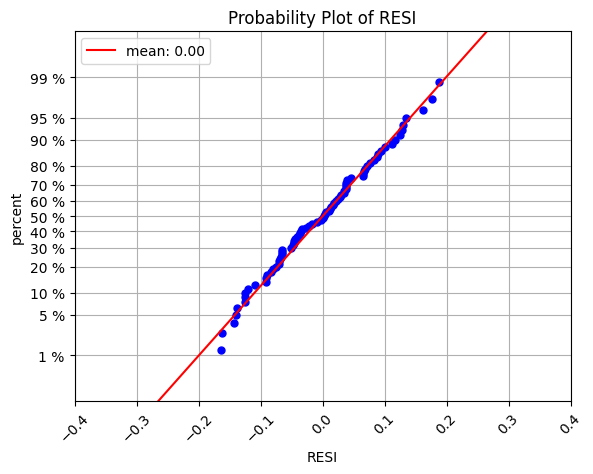

In [20]:
## Probability plot of residuals

#get residuals of model 1
values = est_1.resid

#calculate empirical CDF
cumprob = ECDF(values)(values)

#fit data
loc, scale = stats.norm.fit(values)
pffit = stats.norm(loc=loc,scale=scale)

x = np.linspace(values.min() - 0.4,values.max() + 1.5,3)
ax = plt.subplot(111)
ax.plot(values,cumprob, 'bo', alpha=1, markersize=5)
ax.plot(x,pffit.cdf(x),'r-',label='mean: {:.2f}'.format(loc))

ax.ticklabel_format(style='plain', axis='x')
ax.set_yscale('ppf')
ax.set_ylim(0.001, 0.999)
ax.set_xlim(-0.4,0.4)
ax.grid(True)
ax.legend(loc='best')
plt.xlabel('RESI')
plt.ylabel('percent')
plt.title('Probability Plot of RESI')
plt.xticks(rotation=45)
plt.show()

### Model 2 - X3, X5, X10

#### Model 2 with SK learn

In [26]:
df_m2 = df[['sqft_living', 'floors', 'Built_Renovated', 'log_p']]
X2, y2 = df_m2.iloc[:, :3], df_m2.iloc[:, -1]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 0)

In [37]:
ml = LinearRegression()
sklearn_m2 = ml.fit(X2_train, y2_train)
sklearn_m2_y_pred = sklearn_m2.predict(X2_test)
print(sklearn_m2_y_pred)

[5.54776563 5.65099268 5.65196119 5.8547341  5.81529806 5.62080535
 5.94928827 5.81279635 5.50293951 6.09020176 5.42604662 5.55882727
 5.58987477 5.70138687 5.56422308 5.38205518 6.17209805 5.49725478
 5.5270457  5.81823832 5.88549554 5.4867062  5.80530097 6.03390069]


In [28]:
df_m2.head()

,sqft_living,floors,Built_Renovated,log_p
0,1910,2.0,1997,5.643453
1,1000,1.0,1961,5.328380
2,2085,1.0,1964,5.750894
3,6070,2.0,1999,6.190332
4,6050,2.0,2001,6.204120


In [29]:
## Predict a known value
## We use the first row of df_m2

sklearn_m1.predict([[1910, 2.0, 1997]])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([5.69639665])

In [30]:
r2_score(y2_test, sklearn_m2_y_pred)

0.7318547343658419

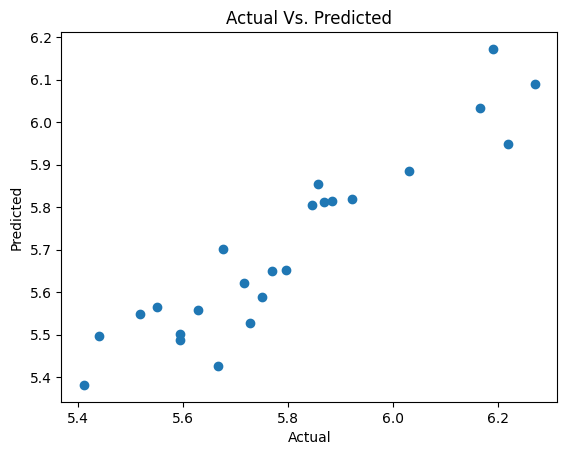

In [31]:
plt.scatter(y2_test, sklearn_m2_y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual Vs. Predicted')
plt.show()

In [39]:
# Regressor coefficients and intercept
print(f'Coefficient: {ml.coef_}')
print(f'Intercept: {ml.intercept_}')

Coefficient: [0.00011351 0.06833668 0.00175905]
Intercept: 1.830103469469571


In [38]:
# Regressor coefficients and intercept
print(f'Coefficient: {sklearn_m2.coef_}')
print(f'Intercept: {sklearn_m2.intercept_}')

Coefficient: [0.00011351 0.06833668 0.00175905]
Intercept: 1.830103469469571


#### Model 2 with Stats Models - R SQ - 82.5%, AR2 - 81.8%

In [42]:
X2 = sm.add_constant(X2)
est = sm.OLS(y2, X2).fit()
results_summary = est.summary()

In [49]:
pd.options.display.float_format = '{:.5f}'.format

In [50]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[0].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0]

,log_p,R-squared:,0.825
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,0.81800
Method:,Least Squares,F-statistic:,119.20000
Date:,"Wed, 13 Mar 2024",Prob (F-statistic):,0.00000
Time:,15:07:21,Log-Likelihood:,73.71400
No. Observations:,80,AIC:,-139.40000
Df Residuals:,76,BIC:,-129.90000
Df Model:,3,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


1. R – Squared = 82.47% and Adjusted R – Squared = 81.78%. Both the values are quite high and indicate this model is a good fit.

2. The F-Value = 119.21 is significantly high.

3. The p – value of regression is 0, so we reject the Null Hypothesis that all coefficients are simultaneously = 0, indicating that at least 1 coefficient is not 0.

In [51]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[1].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,3.01020,1.12700,2.67100,0.00900,0.76600,5.25500
sqft_living,0.00010,0.00001,10.43900,0.00000,0.00000,0.00000
floors,0.06530,0.03000,2.18100,0.03200,0.00600,0.12500
Built_Renovated,0.00120,0.00100,1.99000,0.05000,-0.00000,0.00200


1. The p – value of individual variables is small, indicating that their respective coefficients is not 0 which is preferable.

In [52]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[2].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0]

,5.014,Durbin-Watson:,1.894
Omnibus:,,,
Prob(Omnibus):,0.08200,Jarque-Bera (JB):,5.45600
Skew:,-0.27700,Prob(JB):,0.06530
Kurtosis:,4.15400,Cond. No.,331000.00000


8. The Durbin-Watson Statistic is 1.89, falling in the range of 1.5 – 2.5, indicating little to no autocorrelation in the residuals.

11. Overall, the model is good enough, but it can be improved by adding explanatory variables to the model to increase R – Squared Value

12. The next model will be evaluated using the extra variable Quality Grade since it is the most correlated to Log (Y) among the variables highlighted from Table 3.

In [61]:
from statsmodels.stats.outliers_influence import OLSInfluence
# compute the residuals and other metrics
influence = OLSInfluence(est)
influence

In [62]:
est.resid

0    -0.05870
1    -0.14830
2     0.12950
3    -0.05567
4    -0.04159
       ...   
75   -0.09038
76   -0.10801
77   -0.01782
78   -0.15167
79    0.08974
Length: 80, dtype: float64

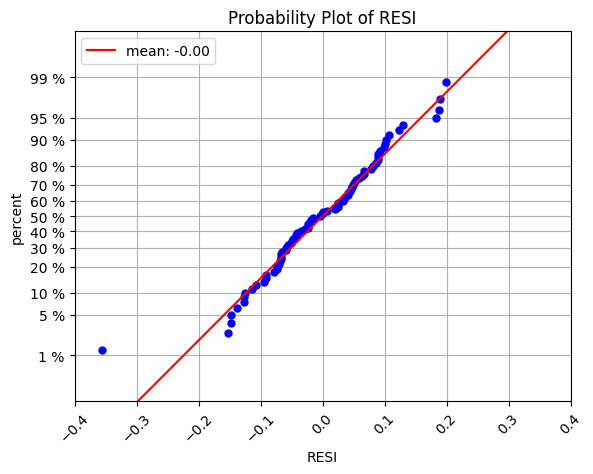

In [73]:
## Probability plot of residuals

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from statsmodels.distributions.empirical_distribution import ECDF

    #generate some data
    values = est.resid

    #calculate empirical CDF
    cumprob = ECDF(values)(values)

    #fit data
    loc, scale = stats.norm.fit(values)
    pffit = stats.norm(loc=loc,scale=scale)

    x = np.linspace(values.min() - 0.4,values.max() + 1.5,3)
    ax = plt.subplot(111)
    ax.plot(values,cumprob, 'bo', alpha=1, markersize=5)
    ax.plot(x,pffit.cdf(x),'r-',label='mean: {:.2f}'.format(loc))

    ax.ticklabel_format(style='plain', axis='x')
    ax.set_yscale('ppf')
    ax.set_ylim(0.001, 0.999)
    ax.set_xlim(-0.4,0.4)
    ax.grid(True)
    ax.legend(loc='best')
    plt.xlabel('RESI')
    plt.ylabel('percent')
    plt.title('Probability Plot of RESI')
    plt.xticks(rotation=45)
    plt.show()

### Explanatory Variables

We plot the relation of various explanatory variables with Log ( Y ) to see if any of the plots stand out.

Two plots, depicting interaction between sqft_above and bedrooms & Quality_Grade and Built_Renovated showed significant variation.

Thus interaction terms `[sqft_above * bedrooms]` & `[Quality_Grade * Built_Renovated]`, will be added to capture their interaction in the model.

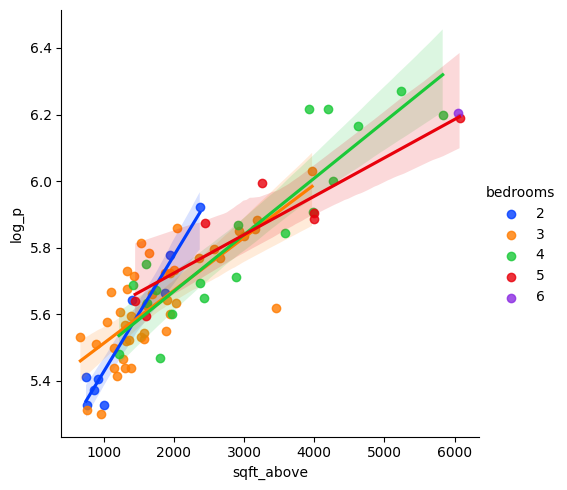

In [118]:
sns.lmplot(data=df, y="log_p", x='sqft_above', hue = 'bedrooms', palette='bright')

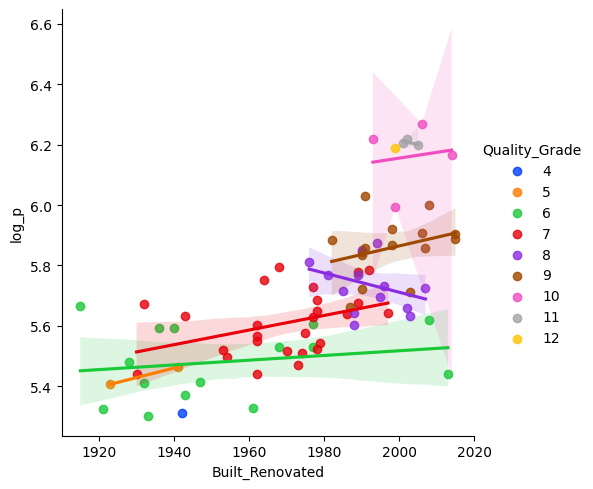

In [115]:
sns.lmplot(data=df, y="log_p", x='Built_Renovated', hue = 'Quality_Grade', palette='bright')

### Model 3 with SM - Built_Renovated * Quality_Grade
---
m3

`R2 - 86.2%`, `AR2 - 85.5%`

m32

`R2 - 86.2%`, `AR3 - 85.5%`

We will use `[Quality_Grade * Built_Renovated]`

In [128]:
df['Var_QB'] = df['Quality_Grade'] * df['Built_Renovated']

In [135]:
df['Var_QB_2'] = df['Quality_Grade'] / df['Built_Renovated']

In [136]:
df_m3 = df[['sqft_living', 'sqft_above', 'Quality_Grade', 'Var_QB', 'log_p']]
X3, y3 = df_m3.iloc[:, :4], df_m3.iloc[:, -1]
X3

,sqft_living,sqft_above,Quality_Grade,Var_QB
0,1910,1910,7,13979
1,1000,1000,6,11766
2,2085,1610,7,13748
3,6070,6070,12,23988
4,6050,6050,11,22011
...,...,...,...,...
75,4000,4000,9,18135
76,4000,4000,9,18135
77,3150,3150,9,18063
78,2580,1360,7,13671


In [137]:
X3 = sm.add_constant(X3)
est_3 = sm.OLS(y3, X3).fit()
results_summary_3 = est_3.summary()

In [138]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_3 = results_summary_3.tables[0].as_html()
pd.read_html(results_3, header=0, index_col=0)[0]

,log_p,R-squared:,0.862
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,0.85500
Method:,Least Squares,F-statistic:,117.20000
Date:,"Wed, 13 Mar 2024",Prob (F-statistic):,0.00000
Time:,18:25:52,Log-Likelihood:,83.30000
No. Observations:,80,AIC:,-156.60000
Df Residuals:,75,BIC:,-144.70000
Df Model:,4,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [133]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_3 = results_summary_3.tables[1].as_html()
pd.read_html(results_3, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.99830,0.08300,60.11700,0.00000,4.83300,5.16400
sqft_living,0.00006,0.00003,2.19400,0.03100,0.00001,0.00000
sqft_above,0.00003,0.00003,1.00600,0.31800,-0.00003,0.00009
Quality_Grade,-0.05690,0.17300,-0.33000,0.74300,-0.40100,0.28700
Var_QB,0.00006,0.00008,0.72500,0.47100,-0.00000,0.00000


In [134]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_3 = results_summary_3.tables[2].as_html()
pd.read_html(results_3, header=0, index_col=0)[0]

,2.352,Durbin-Watson:,1.995
Omnibus:,,,
Prob(Omnibus):,0.30900,Jarque-Bera (JB):,1.97300
Skew:,0.25400,Prob(JB):,0.37300
Kurtosis:,2.42200,Cond. No.,289000.00000


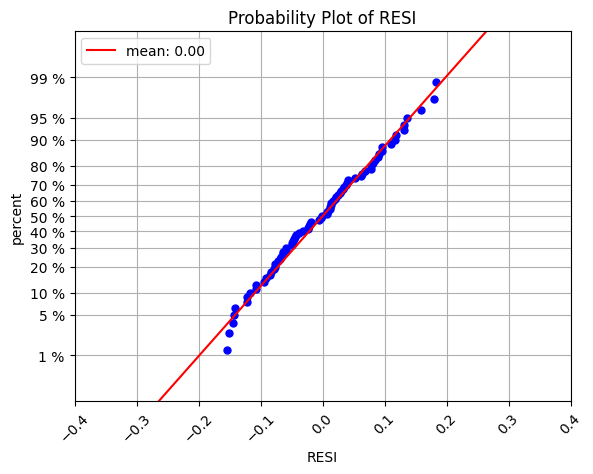

In [162]:
## Probability plot of residuals

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from statsmodels.distributions.empirical_distribution import ECDF

    #generate some data
    values = est_3.resid

    #calculate empirical CDF
    cumprob = ECDF(values)(values)

    #fit data
    loc, scale = stats.norm.fit(values)
    pffit = stats.norm(loc=loc,scale=scale)

    x = np.linspace(values.min() - 0.4,values.max() + 1.5,3)
    ax = plt.subplot(111)
    ax.plot(values,cumprob, 'bo', alpha=1, markersize=5)
    ax.plot(x,pffit.cdf(x),'r-',label='mean: {:.2f}'.format(loc))

    ax.ticklabel_format(style='plain', axis='x')
    ax.set_yscale('ppf')
    ax.set_ylim(0.001, 0.999)
    ax.set_xlim(-0.4,0.4)
    ax.grid(True)
    ax.legend(loc='best')
    plt.xlabel('RESI')
    plt.ylabel('percent')
    plt.title('Probability Plot of RESI')
    plt.xticks(rotation=45)
    plt.show()

In [140]:
df_m3_2 = df[['sqft_living', 'sqft_above', 'Quality_Grade', 'Var_QB_2', 'log_p']]
X32, y32 = df_m3_2.iloc[:, :4], df_m3_2.iloc[:, -1]

In [143]:
X32 = sm.add_constant(X32)
est_32 = sm.OLS(y32, X32).fit()
results_summary_32 = est_32.summary()

In [144]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_32 = results_summary_32.tables[0].as_html()
pd.read_html(results_32, header=0, index_col=0)[0]

,log_p,R-squared:,0.862
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,0.85500
Method:,Least Squares,F-statistic:,117.20000
Date:,"Wed, 13 Mar 2024",Prob (F-statistic):,0.00000
Time:,18:27:06,Log-Likelihood:,83.31100
No. Observations:,80,AIC:,-156.60000
Df Residuals:,75,BIC:,-144.70000
Df Model:,4,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [145]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_32 = results_summary_32.tables[1].as_html()
pd.read_html(results_32, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.99900,0.08300,60.08400,0.00000,4.83300,5.16500
sqft_living,0.00006,0.00003,2.19400,0.03100,0.00001,0.00000
sqft_above,0.00003,0.00003,1.00800,0.31700,-0.00003,0.00009
Quality_Grade,0.18640,0.16100,1.15900,0.25000,-0.13400,0.50700
Var_QB_2,-241.69760,327.20500,-0.73900,0.46200,-893.52300,410.12800


In [146]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_32 = results_summary_32.tables[2].as_html()
pd.read_html(results_32, header=0, index_col=0)[0]

,2.338,Durbin-Watson:,1.994
Omnibus:,,,
Prob(Omnibus):,0.31100,Jarque-Bera (JB):,1.97400
Skew:,0.25600,Prob(JB):,0.37300
Kurtosis:,2.42600,Cond. No.,122000000.00000


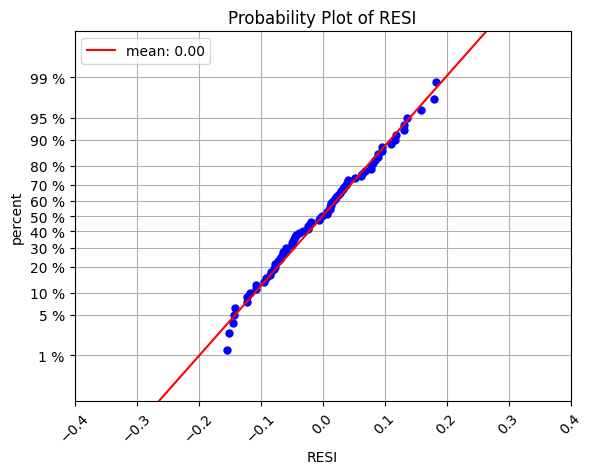

In [163]:
## Probability plot of residuals

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from statsmodels.distributions.empirical_distribution import ECDF

    #generate some data
    values = est_32.resid

    #calculate empirical CDF
    cumprob = ECDF(values)(values)

    #fit data
    loc, scale = stats.norm.fit(values)
    pffit = stats.norm(loc=loc,scale=scale)

    x = np.linspace(values.min() - 0.4,values.max() + 1.5,3)
    ax = plt.subplot(111)
    ax.plot(values,cumprob, 'bo', alpha=1, markersize=5)
    ax.plot(x,pffit.cdf(x),'r-',label='mean: {:.2f}'.format(loc))

    ax.ticklabel_format(style='plain', axis='x')
    ax.set_yscale('ppf')
    ax.set_ylim(0.001, 0.999)
    ax.set_xlim(-0.4,0.4)
    ax.grid(True)
    ax.legend(loc='best')
    plt.xlabel('RESI')
    plt.ylabel('percent')
    plt.title('Probability Plot of RESI')
    plt.xticks(rotation=45)
    plt.show()

### Model 4 with SM - sqft_above * bedrooms
---
m4

`R2 - 86.5%`, `AR2 - 85.8%`

m42

`R2 - 86.3%`, `AR3 - 85.5%`

We will use `[sqft_above * bedrooms]`

In [12]:
df['Var_SB'] = df['sqft_above'] * df['bedrooms']
df['Var_SB_2'] = df['sqft_above'] / df['bedrooms']

In [13]:
df_m4 = df[['sqft_living', 'sqft_above', 'Quality_Grade', 'Var_SB', 'log_p']]
X4, y4 = df_m4.iloc[:, :4], df_m4.iloc[:, -1]

In [14]:
X4 = sm.add_constant(X4)
est_4 = sm.OLS(y4, X4).fit()
results_summary_4 = est_4.summary()

In [151]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_4 = results_summary_4.tables[0].as_html()
pd.read_html(results_4, header=0, index_col=0)[0]

,log_p,R-squared:,0.865
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,0.85800
Method:,Least Squares,F-statistic:,120.30000
Date:,"Wed, 13 Mar 2024",Prob (F-statistic):,0.00000
Time:,18:37:10,Log-Likelihood:,84.20600
No. Observations:,80,AIC:,-158.40000
Df Residuals:,75,BIC:,-146.50000
Df Model:,4,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [152]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_4 = results_summary_4.tables[1].as_html()
pd.read_html(results_4, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.95510,0.06900,71.47300,0.00000,4.81700,5.09300
sqft_living,0.00007,0.00003,2.33500,0.02200,0.00001,0.00000
sqft_above,0.00007,0.00004,1.81600,0.07300,-0.00001,0.00000
Quality_Grade,0.06600,0.01300,5.27300,0.00000,0.04100,0.09100
Var_SB,-0.00001,0.00000,-1.50200,0.13700,-0.00002,0.00000


In [153]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_4 = results_summary_4.tables[2].as_html()
pd.read_html(results_4, header=0, index_col=0)[0]

,1.921,Durbin-Watson:,2.043
Omnibus:,,,
Prob(Omnibus):,0.38300,Jarque-Bera (JB):,1.65000
Skew:,0.21400,Prob(JB):,0.43800
Kurtosis:,2.44100,Cond. No.,78500.00000


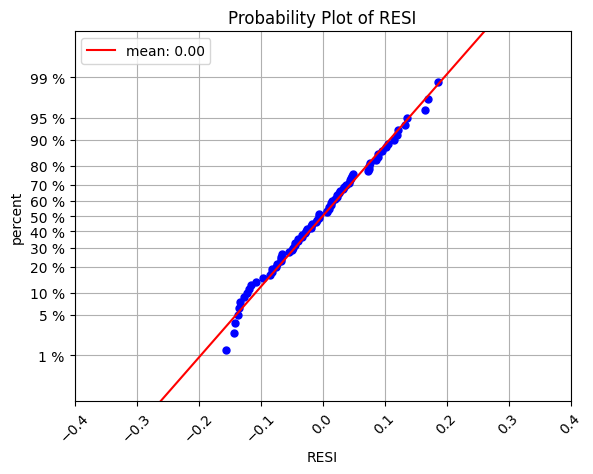

In [21]:
## Probability plot of residuals

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from statsmodels.distributions.empirical_distribution import ECDF

    #generate some data
    values = est_4.resid

    #calculate empirical CDF
    cumprob = ECDF(values)(values)

    #fit data
    loc, scale = stats.norm.fit(values)
    pffit = stats.norm(loc=loc,scale=scale)

    x = np.linspace(values.min() - 0.4,values.max() + 1.5,3)
    ax = plt.subplot(111)
    ax.plot(values,cumprob, 'bo', alpha=1, markersize=5)
    ax.plot(x,pffit.cdf(x),'r-',label='mean: {:.2f}'.format(loc))

    ax.ticklabel_format(style='plain', axis='x')
    ax.set_yscale('ppf')
    ax.set_ylim(0.001, 0.999)
    ax.set_xlim(-0.4,0.4)
    ax.grid(True)
    ax.legend(loc='best')
    plt.xlabel('RESI')
    plt.ylabel('percent')
    plt.title('Probability Plot of RESI')
    plt.xticks(rotation=45)
    plt.show()

In [16]:
df_m4_2 = df[['sqft_living', 'sqft_above', 'Quality_Grade', 'Var_SB_2', 'log_p']]
X42, y42 = df_m4_2.iloc[:, :4], df_m4_2.iloc[:, -1]

In [17]:
X42 = sm.add_constant(X42)
est_42 = sm.OLS(y42, X42).fit()
results_summary_42 = est_42.summary()

In [157]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_42 = results_summary_42.tables[0].as_html()
pd.read_html(results_42, header=0, index_col=0)[0]

,log_p,R-squared:,0.863
Dep. Variable:,,,
Model:,OLS,Adj. R-squared:,0.85500
Method:,Least Squares,F-statistic:,117.70000
Date:,"Wed, 13 Mar 2024",Prob (F-statistic):,0.00000
Time:,18:39:29,Log-Likelihood:,83.45600
No. Observations:,80,AIC:,-156.90000
Df Residuals:,75,BIC:,-145.00000
Df Model:,4,NaN,NaN
Covariance Type:,nonrobust,NaN,NaN


In [158]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_42 = results_summary_42.tables[1].as_html()
pd.read_html(results_42, header=0, index_col=0)[0]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.96060,0.07000,71.02300,0.00000,4.82100,5.10000
sqft_living,0.00006,0.00003,2.23200,0.02900,0.00001,0.00000
sqft_above,0.00002,0.00003,0.63600,0.52600,-0.00004,0.00008
Quality_Grade,0.06640,0.01300,5.23300,0.00000,0.04100,0.09200
Var_SB_2,0.00006,0.00007,0.90600,0.36800,-0.00007,0.00000


In [159]:
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_42 = results_summary_42.tables[2].as_html()
pd.read_html(results_42, header=0, index_col=0)[0]

,2.018,Durbin-Watson:,2.009
Omnibus:,,,
Prob(Omnibus):,0.36500,Jarque-Bera (JB):,1.67900
Skew:,0.20700,Prob(JB):,0.43200
Kurtosis:,2.42400,Cond. No.,27000.00000


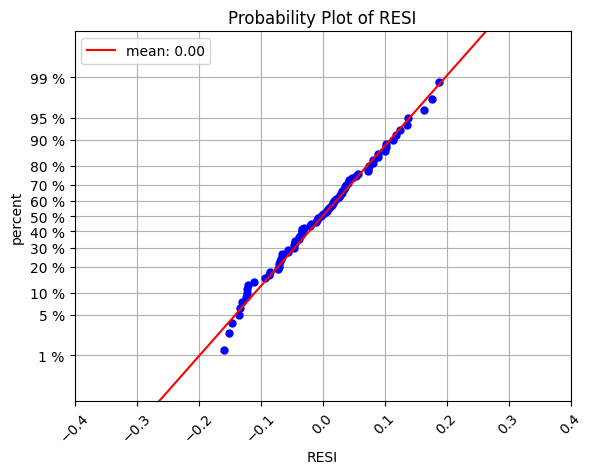

In [22]:
## Probability plot of residuals

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    from statsmodels.distributions.empirical_distribution import ECDF

    #generate some data
    values = est_42.resid

    #calculate empirical CDF
    cumprob = ECDF(values)(values)

    #fit data
    loc, scale = stats.norm.fit(values)
    pffit = stats.norm(loc=loc,scale=scale)

    x = np.linspace(values.min() - 0.4,values.max() + 1.5,3)
    ax = plt.subplot(111)
    ax.plot(values,cumprob, 'bo', alpha=1, markersize=5)
    ax.plot(x,pffit.cdf(x),'r-',label='mean: {:.2f}'.format(loc))

    ax.ticklabel_format(style='plain', axis='x')
    ax.set_yscale('ppf')
    ax.set_ylim(0.001, 0.999)
    ax.set_xlim(-0.4,0.4)
    ax.grid(True)
    ax.legend(loc='best')
    plt.xlabel('RESI')
    plt.ylabel('percent')
    plt.title('Probability Plot of RESI')
    plt.xticks(rotation=45)
    plt.show()